# ライブラリのインストール

In [ ]:
!pip install optuna -q
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.0 MB/s eta 0:00:00


#データの前処理

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/github/利益予測データベース.xlsx'
df = pd.read_excel(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,sample,group,ni_t,ni_t1,ni_t2,ni_t3,ni_t4,ni_t5,cy_e_t1,cy_sale_t1,...,cy_iva_c_t1,cy_intan_c_t1,cy_ap_c_t1,cy_dlc_c_t1,cy_txp_c_t1,cy_dltt_c_t1,cy_re_c_t1,cy_cfo_c_t1,ni_t_mgt,afe_t_mgt
0,201003N0000001,1,0.053142,0.077657,0.073253,0.097867,0.098210,0.067920,0.077657,7.220336,...,-0.025984,0.009102,0.008368,0.135497,-0.011255,0.035526,0.051674,-0.339696,0.088080,0.034939
1,200903N0000001,1,0.083942,0.079182,0.105787,0.106157,0.073416,0.066011,0.079182,7.815907,...,-0.073469,0.002539,-0.052206,-0.333652,0.020470,-0.017614,0.044907,0.587329,0.079340,0.004602
2,200803N0000001,1,0.052085,0.069586,0.069830,0.048293,0.043422,0.039038,0.069586,5.465569,...,-0.083399,0.000139,-0.056052,0.133675,0.000974,-0.031488,0.049406,-0.105840,0.066107,0.014022
3,200703N0000001,1,0.060600,0.060812,0.042056,0.037814,0.033996,0.031088,0.060812,4.632824,...,0.105868,0.005575,0.039057,0.072174,-0.004606,-0.052934,0.043632,0.004212,0.075750,0.015150
4,200603N0000001,1,0.080197,0.055463,0.049869,0.044834,0.040998,0.037042,0.055463,6.099235,...,-0.012547,0.000679,0.018461,-0.114562,0.001758,0.075842,0.035723,-0.049469,0.083914,0.003716


# 特徴量と目的変数


In [ ]:
print(df.columns[2])
print(df.columns[3:8])

ni_t
Index(['ni_t1', 'ni_t2', 'ni_t3', 'ni_t4', 'ni_t5'], dtype='object')


In [ ]:
# iloc：行番号・列番号でDataFrameからデータを取り出す
X = df.iloc[:, 3:8].values
y = df.iloc[:, 2].values      # 利益

# データ分割を、訓練(train)、検証(validation)、テスト(test)の3つに行う



In [ ]:

# Optunaでの評価には検証データを、最終的なモデル性能の評価にはテストデータを使用する

# まず、データ全体を「訓練＋検証データ」(80%)と「テストデータ」(20%)に分割します。
# テストデータは最終評価まで一切使用しません。
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 次に、上で作成した「訓練＋検証データ」を「訓練データ」と「検証データ」に分割します。
# この例では、80%のデータをさらに80%（訓練用）と20%（検証用）に分けています。
# これにより、全体に対して 訓練: 64%, 検証: 16%, テスト: 20% の比率になります。
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# 各データセットの形状（shape）を出力して、分割が正しく行われたか確認します
print(f"訓練データ (X_train) の形状: {X_train.shape}")
print(f"検証データ (X_val) の形状:   {X_val.shape}")
print(f"テストデータ (X_test) の形状:  {X_test.shape}")
print("-" * 40)
print(f"訓練データ (y_train) の形状: {y_train.shape}")
print(f"検証データ (y_val) の形状:   {y_val.shape}")
print(f"テストデータ (y_test) の形状:  {y_test.shape}")

訓練データ (X_train) の形状: (32652, 5)
検証データ (X_val) の形状:   (8163, 5)
テストデータ (X_test) の形状:  (10204, 5)
----------------------------------------
訓練データ (y_train) の形状: (32652,)
検証データ (y_val) の形状:   (8163,)
テストデータ (y_test) の形状:  (10204,)


# 標準化

In [ ]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# 訓練データで fit（平均・標準偏差を計算）し、そのまま transform
X_train_scaled = scaler_x.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# 検証データとテストデータは、訓練データで学習したScalerを使って transform のみ行う
# (ここでfitしてはいけない、データリークになるため)
X_val_scaled = scaler_x.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

X_test_scaled = scaler_x.transform(X_test)
# y_testは最終評価にのみ使用するため、スケーリングは必須ではないが、一貫性のために行っておく
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# StandardScalerは2次元配列を要求するため、1次元のy_trainを(-1,1)にreshapeしてから標準化
# 標準化後はflatten()で再び1次元配列に戻す

In [ ]:
# 形状を確認
print("--- スケーリング後のデータ形状 ---")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_val_scaled:   {X_val_scaled.shape}")
print(f"X_test_scaled:  {X_test_scaled.shape}")

--- スケーリング後のデータ形状 ---
X_train_scaled: (32652, 5)
X_val_scaled:   (8163, 5)
X_test_scaled:  (10204, 5)


#Transformer回帰モデル定義



```
 d_model : # Transformerの埋め込み次元数（モデル内部の特徴表現次元、例：128）
 num_layers : # Encoder層の数（スタックするTransformer層の数）
 dim_feedforward : # 前方フィードフォワード層の隠れユニット数（通常d_modelより大きい）
```



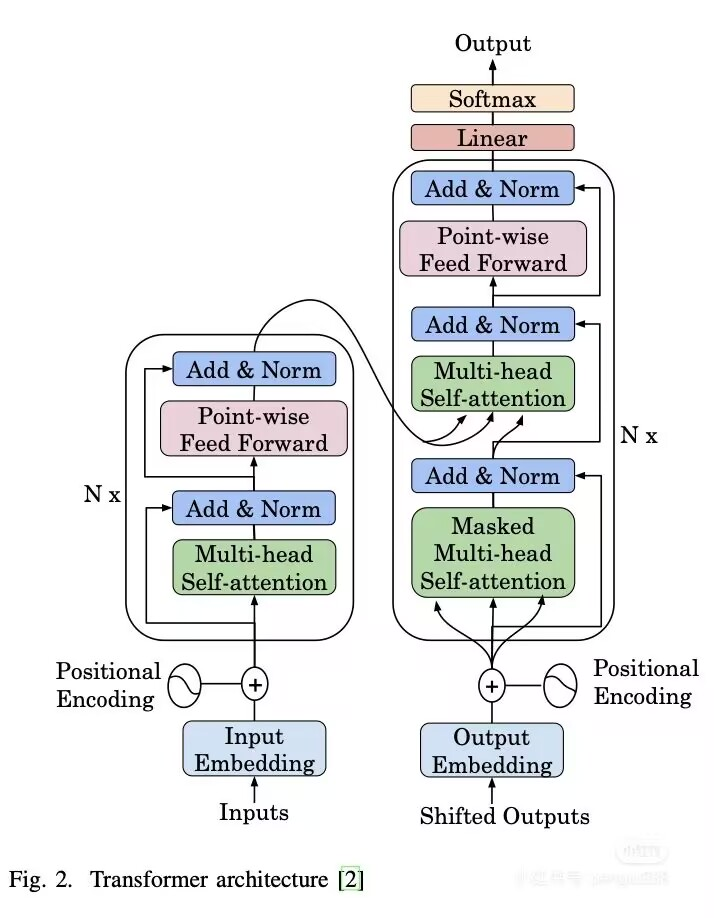

In [ ]:
class TransformerRegressor(nn.Module):
    def __init__(self, feature_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super().__init__()
        # 1. 入力層 (Input Projection)
        self.input_proj = nn.Linear(feature_dim, d_model) # 入力特徴量（元の次元）をd_model次元に射影（しゃえい）する全結合層（ぜんけつごうそう）.例：5つの財務指標を128次元ベクトルに変換

        # 2. Transformerエンコーダ層
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # パフォーマンス向上のための推奨設定
         )

        # 3. 出力層 (Regressor Head)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers) # encoder_layerをnum_layers層分スタックしたTransformerエンコーダ全体を作成，1層の積み木をN層に重ねて、深い表現力を持たせる）
        self.regressor = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
      # x: [batch_size, features]
        x = self.input_proj(x)      # -> [batch_size, d_model]

      # batch_first=Trueのため、[batch_size, seq_len, d_model]の形状に合わせる
        x = x.unsqueeze(1)          # -> [batch_size, seq_len=1, d_model]

        x = self.transformer_encoder(x) # -> same shape
        x = x.squeeze(1)            # -> [batch_size, d_model]

        out = self.regressor(x)     # -> [batch_size, 1]
        return out.squeeze(1)       # -> [batch_size]

"""
    batch_first=False　の　時に
    def forward(self, x):
    # x: [batch_size, features]
    # Transformer expects [sequence_length, batch_size, d_model]
      x = self.input_proj(x)          # -> [batch_size, d_model]
      x = x.unsqueeze(0)              # -> [seq_len=1, batch_size, d_model]
      x = self.transformer_encoder(x) # -> same shape
      x = x.squeeze(0)                # -> [batch_size, d_model]
      out = self.regressor(x)         # -> [batch_size, 1]
      return out.squeeze(1)           # -> [batch_size]
"""

'\n    def forward(self, x):\n    # x: [batch_size, features]\n    # Transformer expects [sequence_length, batch_size, d_model]\n      x = self.input_proj(x)          # -> [batch_size, d_model]\n      x = x.unsqueeze(0)              # -> [seq_len=1, batch_size, d_model]\n      x = self.transformer_encoder(x) # -> same shape\n      x = x.squeeze(0)                # -> [batch_size, d_model]\n      out = self.regressor(x)         # -> [batch_size, 1]\n      return out.squeeze(1)           # -> [batch_size]\n'

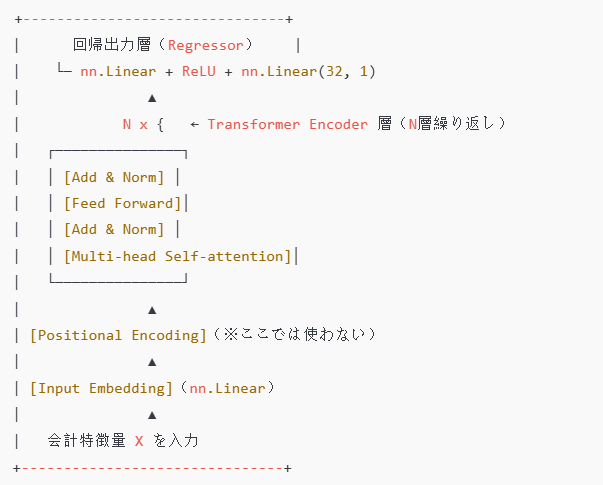


# Optuna objective 関数

| 代码                          | 作用（日语）       | 用法例子           |
| --------------------------- | ------------ | -------------- |
| `trial.suggest_categorical` | 候補リストから選ぶ    | `[64, 128]` など |
| `trial.suggest_int`         | 整数を範囲から選ぶ    | `2, 4`         |
| `trial.suggest_float`       | 実数を範囲から選ぶ    | `0.0, 0.2`     |
| `trial.suggest_float`  | 対数スケールの実数を選ぶ | `1e-4, 1e-1, log=True`   |


In [ ]:
def objective(trial):
    # ハイパーパラメータのサンプリング範囲を定義
    d_model = trial.suggest_categorical('d_model', [64, 128])
    nhead = trial.suggest_categorical('nhead', [4, 8])
    num_layers = trial.suggest_int('num_layers', 2, 4)    # エンコーダー層の数
    dim_feedforward = trial.suggest_int('dim_feedforward', 128, 256, step=64)  # FFNの隠れ層次元
    dropout = trial.suggest_float('dropout', 0.0, 0.2)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = 10   # 短めのepochで評価

    model = TransformerRegressor(
        feature_dim=X_train_scaled.shape[1],
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    )
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    dataset = TensorDataset(
        torch.tensor(X_train_scaled, dtype=torch.float32),
        torch.tensor(y_train_scaled, dtype=torch.float32)
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(10):
        model.train()
        for xb, yb in loader:# 訓練モード
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

    # 最終評価：訓練がすべて完了した後、検証データで性能を一度だけ評価
    model.eval()
    with torch.no_grad():
      X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
      # モデルの予測値（スケーリングされたまま）
      y_val_pred_scaled = model(X_val_tensor)

      # 標準化された予測値を元のスケールに逆変換（テンソル→NumPy→reshape→逆変換→1次元に戻す）
      y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.numpy().reshape(-1, 1)).flatten()

    return mean_absolute_error(y_val, y_val_pred)


# Optuna 実行と可視化


In [ ]:
import plotly.io as pio
# Colab環境でプロットを正しく表示するための設定です
pio.renderers.default = "colab"

# ステップ1: studyオブジェクトを作成します。
# 私たちの目標はMAE（平均絶対誤差）を最小にすることなので、direction='minimize'と設定します。
study = optuna.create_study(direction='minimize')

# ステップ2: 最適化を実行します。
# objective関数を30回試行(n_trials=30)して、最適なハイパーパラメータを探します。
# この処理には数分かかることがあります。
print("optunaによるハイパーパラメータ探索を開始します...")
study.optimize(objective, n_trials=30)

# 探索完了後に結果を出力します。
print("\n探索が完了しました。")
print(f"最良スコア (検証MAE): {study.best_value}")
print("最良のハイパーパラメータ:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# ステップ3: 結果を可視化します。
from optuna.visualization import plot_optimization_history, plot_param_importances

print("\n--- 可視化結果 ---")

# 探索履歴のプロット
# 各試行でMAEがどのように改善されていったかを確認できます。
fig1 = plot_optimization_history(study)
fig1.show()

# ハイパーパラメータの重要度のプロット
# どのパラメータが最終的なスコアに最も影響を与えたかを確認できます。
fig2 = plot_param_importances(study)
fig2.show()

[I 2025-06-28 03:07:32,156] A new study created in memory with name: no-name-27a173ca-f388-4613-bad9-bb9a29fc857f


optunaによるハイパーパラメータ探索を開始します...


[I 2025-06-28 03:08:35,400] Trial 0 finished with value: 0.05816761651861704 and parameters: {'d_model': 64, 'nhead': 4, 'num_layers': 2, 'dim_feedforward': 192, 'dropout': 0.17047132214004548, 'learning_rate': 4.5315685996733725e-05, 'batch_size': 64}. Best is trial 0 with value: 0.05816761651861704.
[I 2025-06-28 03:11:03,483] Trial 1 finished with value: 0.05934223855539065 and parameters: {'d_model': 128, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 192, 'dropout': 0.09110130288947729, 'learning_rate': 3.265518587042144e-05, 'batch_size': 32}. Best is trial 0 with value: 0.05816761651861704.
[I 2025-06-28 03:11:42,862] Trial 2 finished with value: 0.05776744905149387 and parameters: {'d_model': 64, 'nhead': 4, 'num_layers': 3, 'dim_feedforward': 192, 'dropout': 0.19441621230862252, 'learning_rate': 0.0005487788623134473, 'batch_size': 128}. Best is trial 2 with value: 0.05776744905149387.
[I 2025-06-28 03:12:20,049] Trial 3 finished with value: 0.059573409335224516 and parameter


探索が完了しました。
最良スコア (検証MAE): 0.05751536621768135
最良のハイパーパラメータ:
  d_model: 128
  nhead: 8
  num_layers: 4
  dim_feedforward: 128
  dropout: 0.09991145969481097
  learning_rate: 0.0005947223871239946
  batch_size: 128

--- 可視化結果 ---


# 最終モデルの訓練と評価

In [ ]:
print("--- ステップ4: 最終モデルの訓練と評価を開始します ---")

# 1. Optunaで見つけた最良のハイパーパラメータを取得します
best_params = study.best_params  # ディクショナリ
print("\n取得した最良のハイパーパラメータ:")
print(best_params)

# 2. 最良のパラメータで最終モデルを初期化します
final_model = TransformerRegressor(
    feature_dim=X_train_scaled.shape[1],
    d_model=best_params['d_model'],
    nhead=best_params['nhead'],
    num_layers=best_params['num_layers'],
    dim_feedforward=best_params['dim_feedforward'],
    dropout=best_params['dropout']
)

# 3. 最終訓練のために、訓練データと検証データを結合して使用します
# 検証データはパラメータ選択の役目(やくめ)を終えたので、今は訓練データとして活用します
X_train_val_scaled = scaler_x.transform(X_train_val)
y_train_val_scaled = scaler_y.transform(y_train_val.reshape(-1, 1)).flatten()

final_dataset = TensorDataset(
    torch.tensor(X_train_val_scaled, dtype=torch.float32),
    torch.tensor(y_train_val_scaled, dtype=torch.float32)
)
final_loader = DataLoader(final_dataset, batch_size=best_params['batch_size'], shuffle=True)

# 4. 最適化手法と損失関数を定義します
final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
loss_fn = nn.MSELoss()

# 5. 最終モデルの訓練ループを開始します
# 探索時より多いエポック数で、モデルが十分に学習するようにします
final_epochs = 50
print(f"\n最終モデルの訓練を開始 (エポック数: {final_epochs})")
for epoch in range(final_epochs):
    final_model.train()
    epoch_loss = 0
    for xb, yb in final_loader:
        final_optimizer.zero_grad()
        pred = final_model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        final_optimizer.step()
        epoch_loss += loss.item()

    # 10エポックごとに訓練ロスを表示
    if (epoch + 1) % 10 == 0:
        print(f"エポック [{epoch+1}/{final_epochs}], 訓練ロス: {epoch_loss/len(final_loader):.4f}")

print("\n最終モデルの訓練が完了しました。")

# 6. テストデータで最終評価を行います
# これはモデルの未知のデータに対する性能を測る、一度きりの評価です
print("\n--- 最終評価 (テストデータ) ---")
final_model.eval()
with torch.no_grad():
    # テストデータをテンソルに変換
    test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    # 予測を実行
    test_pred_scaled = final_model(test_tensor)

    # 予測値を元のスケールに戻す
    y_test_pred = scaler_y.inverse_transform(test_pred_scaled.cpu().numpy().reshape(-1, 1)).flatten()

# 7. 最終的なMAEを計算して表示します
final_mae = mean_absolute_error(y_test, y_test_pred)
print(f"\nテストデータにおける最終的なMAE: {final_mae:.4f}")

--- ステップ4: 最終モデルの訓練と評価を開始します ---

取得した最良のハイパーパラメータ:
{'d_model': 128, 'nhead': 8, 'num_layers': 4, 'dim_feedforward': 128, 'dropout': 0.09991145969481097, 'learning_rate': 0.0005947223871239946, 'batch_size': 128}

最終モデルの訓練を開始 (エポック数: 50)
エポック [10/50], 訓練ロス: 0.8049
エポック [20/50], 訓練ロス: 0.8006
エポック [30/50], 訓練ロス: 0.7997
エポック [40/50], 訓練ロス: 0.7992
エポック [50/50], 訓練ロス: 0.7988

最終モデルの訓練が完了しました。

--- 最終評価 (テストデータ) ---

テストデータにおける最終的なMAE: 0.0598
